## Merging weather data with delay data to find patterns

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

In [2]:
# load weather data
weather_df = pd.read_csv('data/weather_01.csv').drop(columns="Unnamed: 0")
# load flight data for airports for which we have weather data
flights_df = pd.read_csv('data/flights_sample_random_cleaned.csv').drop(columns="Unnamed: 0")
airports = weather_df.airport.unique()
cond = flights_df.origin.isin(airports)
flights_df = flights_df[cond]

In [3]:
flights_df.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,...,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
4,2018-07-22,UA,UA,UA,2048,UA,2048,12892,LAX,"Los Angeles, CA",...,75.0,64.0,44.0,1.0,236.0,0.0,0.0,0.0,0.0,0.0
5,2019-03-24,DL,DL,DL,416,DL,416,10397,ATL,"Atlanta, GA",...,109.0,97.0,79.0,1.0,545.0,0.0,0.0,0.0,0.0,0.0
6,2018-06-14,DL,DL_CODESHARE,DL,4766,OO,4766,10397,ATL,"Atlanta, GA",...,49.0,45.0,21.0,1.0,83.0,0.0,0.0,0.0,0.0,0.0
7,2018-09-29,AA,AA,AA,1014,AA,1014,12892,LAX,"Los Angeles, CA",...,177.0,170.0,149.0,1.0,1242.0,0.0,0.0,0.0,0.0,0.0
11,2019-04-14,UA,UA,UA,260,UA,260,14747,SEA,"Seattle, WA",...,294.0,289.0,257.0,1.0,2306.0,0.0,0.0,32.0,0.0,0.0


In [4]:
# add weather and windspeed columns

def weather(row):
    apt = row.origin
    date = row.fl_date
    c1, c2 = weather_df.airport == apt, weather_df.date == date
    try:
        w = weather_df[c1 & c2].iloc[0]
        return w.weather
    except:
        return np.nan

def windspeed(row):
    apt = row.origin
    date = row.fl_date
    c1, c2 = weather_df.airport == apt, weather_df.date == date
    try:
        w = weather_df[c1 & c2].iloc[0]
        return w.windspeed
    except:
        return np.nan
    
flights_df['weather'] = flights_df.apply(weather, 1)
flights_df['windspeed'] = flights_df.apply(windspeed, 1)

In [5]:
# drop null columns
cond = flights_df.weather.notnull()
flights_df = flights_df[cond]

In [6]:
flights_df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'op_carrier_fl_num',
       'origin_airport_id', 'origin', 'origin_city_name', 'dest_airport_id',
       'dest', 'dest_city_name', 'crs_dep_time', 'dep_time', 'dep_delay',
       'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'crs_arr_time',
       'arr_time', 'arr_delay', 'cancelled', 'cancellation_code', 'diverted',
       'dup', 'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'weather', 'windspeed'],
      dtype='object')

In [7]:
# copy only relevant features
df = flights_df[['fl_date', 'origin', 'dep_delay', 'arr_delay', 'cancelled', 'cancellation_code', 'diverted',
       'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'weather', 'windspeed']].copy()

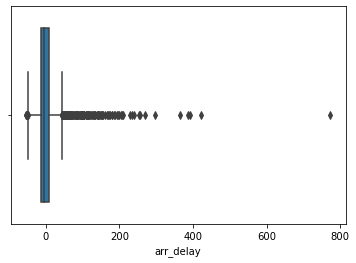

In [8]:
# see distribution for delays
sns.boxplot(x=df.arr_delay)

In [9]:
# function "borrowed" from Robyn
def rem_outliers(df, col):
    ''' Remove outliers which fall outside of 3 standard deviations above and below the mean of the data set
            Input
                (0) dataframe containing the data
                (1) column to remove outliers from
            Output
                rows of df which are classified as outliers in the specified column are directly removed
                print out stating count of outliers removed '''
    mean, cutoff = np.mean(df[col]), np.std(df[col]) * 3   # 3 stddev outside the mean
    lower, upper = mean - cutoff, mean + cutoff
    outliers = [x for x in df[col] if x < lower or x > upper]
    df.drop(df[(df[col] > upper) | (df[col] < lower)].index, inplace=True)
    return f'{len(outliers)} outliers removed'

In [10]:
rem_outliers(df, 'arr_delay')

'39 outliers removed'

Text(0.5, 0, 'Arrival delay')

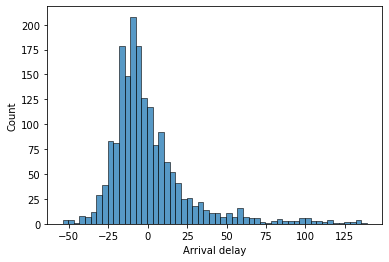

In [11]:
# see distribution for delays again
ax = sns.histplot(x=df.arr_delay)
ax.set_xlabel("Arrival delay")

Text(0, 0.5, 'Arrival delay')

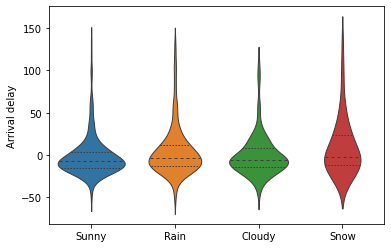

In [12]:
x = df.weather.to_numpy()
y = df.arr_delay.to_numpy()

ax = sns.violinplot(x=x, y=y, split=True, inner="quart", linewidth=1)
ax.set_ylabel("Arrival delay")

Based on raw correlation, weather doesn't significantly affect the arrival delay. However, snow seems to have a significant effect on the variance. I'll dig a little deeper.

In [19]:
weather_dummies = pd.get_dummies(df.weather, prefix='weather')

In [23]:
df = pd.concat([df, weather_dummies], axis=1)

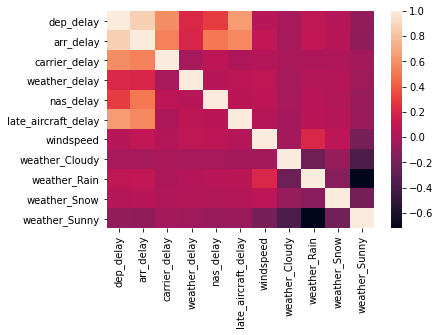

In [33]:
df_num = df[['dep_delay', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
             'late_aircraft_delay', 'windspeed', 'weather_Cloudy',
             'weather_Rain', 'weather_Snow', 'weather_Sunny']]

sns.heatmap(df_num.corr())